In [1]:
import pandas as pd
import ladybug_pandas as lbp

Successfully imported Ladybug plugin: ladybug_geometry
Successfully imported Ladybug plugin: ladybug_pandas


# Working With Ladybug Arrays

The Ladybug Pandas plugin introduces an Extension Array Type. These new array types contain numpy float array and information concerning the Data Type (Temperature, Pressure etc...) and Unit (Celsius, Kelvin, Pascal etc..).

The list of avaiable data types and units can be found in the list of data type submodules in the [Ladybug docs](https://www.ladybug.tools/ladybug/docs/ladybug.datatype.html#submodules).

We will cover some of the things you can do with Ladybug Arrays when saved as Series and Dataframes.

First let's load an EPW so we can play with ladybug data collections.

In [2]:
from ladybug.epw import EPW

epw_path = '../tests/assets/epw/tokyo.epw'

epw = EPW(epw_path)

epw._import_data()

## Data Types and Units

The main benefit of using the Ladybug Extension Array types is that they contain information on the data type and the unit of the data within the Array much like ladybug data collections.

As you can see below the `dtype` of the series object below is "Dry Bulb Temperature (C)". In this case the data type is "Dry Bulb Temperature" and the unit is "Celsius". By keeping track of units we can ensure that operations between pandas series can be converted to correct units or generate correct output data types.

ie: a Temperature + another Temperature generates a temperature but a Temperature + Pressure generates an "unknown" data type.

We have created specific "accessors" which allow you to perform helpful operations on Ladybug Arrays such as unit conversion and psychrometric calculations.

Let's run you through some examples.

### Series

We can use the `ladybug` accessor to convert a Series to different units. There are three main methods:

* `to_si`: Converts the series to a SI unit
* `to_ip`: Converts the series to an IP unit
* `to_si`: Converts the series to a unit of your choosing so long as it makes sense for the given data type (ie: can't convert a temperature to a Pa unit)

#### Generate from Data Collections

Extract a Ladybug Array of type "Dry Bulb Temperature" from a DataFrame

In [3]:
series = lbp.series_from_collection(epw.dry_bulb_temperature)

series

2017-01-01 00:00:00   3.1
2017-01-01 01:00:00   3.8
2017-01-01 02:00:00   3.6
2017-01-01 03:00:00   2.9
2017-01-01 04:00:00   3.2
                       ..
2017-12-31 19:00:00   4.6
2017-12-31 20:00:00   4.1
2017-12-31 21:00:00   3.8
2017-12-31 22:00:00   3.3
2017-12-31 23:00:00   3.1
Length: 8760, dtype: Dry Bulb Temperature (C)

#### IP Conversion
Convert to IP units by using the `ladybug` accessor

In [7]:
series.ladybug.to_ip()

2017-01-01 00:00:00                37.58
2017-01-01 01:00:00   38.839999999999996
2017-01-01 02:00:00                38.48
2017-01-01 03:00:00                37.22
2017-01-01 04:00:00                37.76
                             ...        
2017-12-31 19:00:00                40.28
2017-12-31 20:00:00                39.38
2017-12-31 21:00:00   38.839999999999996
2017-12-31 22:00:00                37.94
2017-12-31 23:00:00                37.58
Length: 8760, dtype: Dry Bulb Temperature (F)

In [5]:
series.ladybug.to_si()

2017-01-01 00:00:00   -16.055555555555557
2017-01-01 01:00:00   -15.666666666666666
2017-01-01 02:00:00   -15.777777777777779
2017-01-01 03:00:00   -16.166666666666668
2017-01-01 04:00:00                 -16.0
                              ...        
2017-12-31 19:00:00   -15.222222222222221
2017-12-31 20:00:00                 -15.5
2017-12-31 21:00:00   -15.666666666666666
2017-12-31 22:00:00   -15.944444444444445
2017-12-31 23:00:00   -16.055555555555557
Length: 8760, dtype: Dry Bulb Temperature (C)

#### Arbitrary Unit Conversion
Convert the Series to another valid unit. Here we convert the array to Kelvin.

In [6]:
series.ladybug.to_unit('K')

2017-01-01 00:00:00               276.25
2017-01-01 01:00:00               276.95
2017-01-01 02:00:00               276.75
2017-01-01 03:00:00   276.04999999999995
2017-01-01 04:00:00   276.34999999999997
                             ...        
2017-12-31 19:00:00               277.75
2017-12-31 20:00:00               277.25
2017-12-31 21:00:00               276.95
2017-12-31 22:00:00               276.45
2017-12-31 23:00:00               276.25
Length: 8760, dtype: Dry Bulb Temperature (K)

#### Incorrect Unit Conversion
Attempting to convert the series into an incorrect unit type will result in a helpful error.

In [7]:
try:
    series.ladybug.to_unit('Pa')
except Exception as err:
    print(err)

Pa is not an acceptable unit type for DryBulbTemperature. Choose from the following: ('C', 'F', 'K')


### DataFrames

Working with dataframes composed of Ladybug Arrays is very similar to working with Series of that array type. Dataframes have the same `ladybug` accessor than can perform similar unit conversion operations.

#### Loading Data Collections

You can create dataframes of Ladybug Arrays by loading a list of ladybug data collections. Here is an example of loading WEA data into a dataframe using the `dataframe_from_collections` function.

In [8]:
from ladybug.wea import Wea
from ladybug.location import Location

location = Location(
    city='Llanfairpwllgwyngyllgogerychwyrndrobwllllantysiliogogogoch',
    state='Wales',
    country='United Kingdom',
    latitude=53.224622,
    longitude=-4.197995,
    time_zone=0
)

wea = Wea.from_ashrae_clear_sky(location=location)

data_collections = [
    wea.direct_normal_irradiance,
    wea.diffuse_horizontal_irradiance,
    wea.global_horizontal_irradiance,
    wea.direct_horizontal_irradiance,
]

df = lbp.dataframe_from_collections(data_collections)

print("DataFrame Column Types")
print()
print(df.dtypes)

df[8:18]

DataFrame Column Types

Direct Normal Irradiance              Direct Normal Irradiance (W/m2)
Diffuse Horizontal Irradiance    Diffuse Horizontal Irradiance (W/m2)
Global Horizontal Irradiance      Global Horizontal Irradiance (W/m2)
Direct Horizontal Irradiance      Direct Horizontal Irradiance (W/m2)
dtype: object


,Direct Normal Irradiance,Diffuse Horizontal Irradiance,Global Horizontal Irradiance,Direct Horizontal Irradiance
2017-01-01 08:00:00,0.0,0.0,0.0,-0.0
2017-01-01 09:00:00,277.53189327141,4.53841661972295,31.23498497103442,26.696568351311473
2017-01-01 10:00:00,543.2306210445728,16.39524560066836,112.83786678107047,96.44262118040211
2017-01-01 11:00:00,645.3261586103945,24.869469262840642,171.1604649266091,146.29099566376846
2017-01-01 12:00:00,667.1657439588372,27.164710145654286,186.95712276715008,159.7924126214958
2017-01-01 13:00:00,623.9132314086693,22.806920096138704,156.96527360283696,134.15835350669826
2017-01-01 14:00:00,484.28717678205317,12.769577353388057,87.88473825567074,75.11516090228268
2017-01-01 15:00:00,158.2965966121899,1.8716630425185434,12.881445645568798,11.009782603050255
2017-01-01 16:00:00,0.0,0.0,0.0,-0.0
2017-01-01 17:00:00,0.0,0.0,0.0,-0.0


#### Loading an EPW

We have also introduced a convenience function to load EPWs into a dataframe. Under the hood this function calls the `dataframe_from_collections` for a specific subset of data collections in the EPW.

Note that `null` values which are usually set to 9999999.00 are replaced by numpy.nan values

In [9]:
df = lbp.dataframe_from_epw(epw)

print("DataFrame Column Types")
print()
print(df.dtypes)

df[8:18]

DataFrame Column Types

Dry Bulb Temperature                                                Dry Bulb Temperature (C)
Dew Point Temperature                                              Dew Point Temperature (C)
Relative Humidity                                                      Relative Humidity (%)
Atmospheric Station Pressure                               Atmospheric Station Pressure (Pa)
Extraterrestrial Horizontal Radiation          Extraterrestrial Horizontal Radiation (Wh/m2)
Extraterrestrial Direct Normal Radiation    Extraterrestrial Direct Normal Radiation (Wh/m2)
Horizontal Infrared Radiation Intensity       Horizontal Infrared Radiation Intensity (W/m2)
Global Horizontal Radiation                              Global Horizontal Radiation (Wh/m2)
Direct Normal Radiation                                      Direct Normal Radiation (Wh/m2)
Diffuse Horizontal Radiation                            Diffuse Horizontal Radiation (Wh/m2)
Global Horizontal Illuminance                 

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
2017-01-01 08:00:00,2.2,-2.25031591728358,72.0,93900.0,185.0,1415.0,236.0,326.0,706.0,89.0,...,77777.0,9.0,nan,100.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 09:00:00,3.5,-1.83792816367003,68.0,94000.0,394.0,1415.0,241.0,453.0,878.0,64.0,...,77777.0,9.0,nan,100.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 10:00:00,5.4,-2.68439978922253,56.0,93900.0,555.0,1415.0,246.0,538.0,867.0,100.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 11:00:00,6.5,-3.57903448408041,49.0,93900.0,655.0,1415.0,248.0,528.0,858.0,83.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 12:00:00,7.9,-4.04882214414673,43.0,93800.0,688.0,1415.0,252.0,481.0,842.0,78.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 13:00:00,8.2,-6.63496367579454,34.0,93800.0,651.0,1415.0,248.0,390.0,747.0,97.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 14:00:00,8.1,-7.21158745013852,33.0,93800.0,546.0,1415.0,246.0,214.0,392.0,111.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 15:00:00,7.6,-7.81137630382064,33.0,93700.0,382.0,1415.0,243.0,39.0,25.0,36.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 16:00:00,7.2,-7.8106023754102,34.0,93700.0,170.0,1415.0,242.0,0.0,0.0,0.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 17:00:00,6.2,-8.43552989734887,34.0,93700.0,6.0,342.0,237.0,0.0,0.0,0.0,...,77777.0,9.0,nan,110.0,0.068,0.0,88.0,0.17,0.0,1.0


#### Unit Conversions

Dataframes can be converted to SI and IP units much like Ladybug Array Series can. The examples below demonstrate conversion to and from IP and SI as well as a custom unit.

#### IP Conversion

In [10]:
df = df.ladybug.to_ip()

print("DataFrame Column Types")
print()
print(df.dtypes)

df[8:18]

DataFrame Column Types

Dry Bulb Temperature                                                 Dry Bulb Temperature (F)
Dew Point Temperature                                               Dew Point Temperature (F)
Relative Humidity                                                       Relative Humidity (%)
Atmospheric Station Pressure                              Atmospheric Station Pressure (inHg)
Extraterrestrial Horizontal Radiation         Extraterrestrial Horizontal Radiation (Btu/ft2)
Extraterrestrial Direct Normal Radiation    Extraterrestrial Direct Normal Radiation (Btu/...
Horizontal Infrared Radiation Intensity     Horizontal Infrared Radiation Intensity (Btu/h...
Global Horizontal Radiation                             Global Horizontal Radiation (Btu/ft2)
Direct Normal Radiation                                     Direct Normal Radiation (Btu/ft2)
Diffuse Horizontal Radiation                           Diffuse Horizontal Radiation (Btu/ft2)
Global Horizontal Illuminance       

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
2017-01-01 08:00:00,35.96,27.949431348889554,72.0,27.72867,58644.63,448552.17,74.81160591116296,103341.348,223800.588,28212.822,...,255173.89268,9.0,nan,3937.01,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 09:00:00,38.3,28.691729305393945,68.0,27.758200000000002,124897.212,448552.17,76.39659756182319,143600.09399999998,278324.244,20287.872,...,255173.89268,9.0,nan,3937.01,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 10:00:00,41.72,27.168080379399445,56.0,27.72867,175933.88999999998,448552.17,77.98158921248343,170544.924,274837.266,31699.8,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 11:00:00,43.7,25.55773792865526,49.0,27.72867,207633.69,448552.17,78.61558587274752,167374.944,271984.284,26310.834,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 12:00:00,46.22,24.712120140535887,43.0,27.699140000000003,218094.62399999998,448552.17,79.88357919327571,152476.038,266912.316,24725.844,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 13:00:00,46.76,20.057065383569828,34.0,27.699140000000003,206365.698,448552.17,78.61558587274752,123629.22,236797.506,30748.806,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 14:00:00,46.58,19.019142589750665,33.0,27.699140000000003,173080.908,448552.17,77.98158921248343,67837.572,124263.216,35186.778,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 15:00:00,45.68,17.939522653122847,33.0,27.669610000000002,121093.23599999999,448552.17,77.03059422208729,12362.922,7924.95,11411.928,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 16:00:00,44.96,17.94091572426164,34.0,27.669610000000002,53889.659999999996,448552.17,76.71359589195524,0.0,0.0,0.0,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 17:00:00,43.16,16.816046184772034,34.0,27.669610000000002,1901.9879999999998,108413.31599999999,75.12860424129501,0.0,0.0,0.0,...,255173.89268,9.0,nan,4330.711,0.068,0.0,88.0,0.17,0.0,1.0


#### SI Conversion

In [11]:
df = df.ladybug.to_si()

print("DataFrame Column Types")
print()
print(df.dtypes)

df[8:18]

DataFrame Column Types

Dry Bulb Temperature                                                Dry Bulb Temperature (C)
Dew Point Temperature                                              Dew Point Temperature (C)
Relative Humidity                                                      Relative Humidity (%)
Atmospheric Station Pressure                               Atmospheric Station Pressure (Pa)
Extraterrestrial Horizontal Radiation          Extraterrestrial Horizontal Radiation (Wh/m2)
Extraterrestrial Direct Normal Radiation    Extraterrestrial Direct Normal Radiation (Wh/m2)
Horizontal Infrared Radiation Intensity       Horizontal Infrared Radiation Intensity (W/m2)
Global Horizontal Radiation                              Global Horizontal Radiation (Wh/m2)
Direct Normal Radiation                                      Direct Normal Radiation (Wh/m2)
Diffuse Horizontal Radiation                            Diffuse Horizontal Radiation (Wh/m2)
Global Horizontal Illuminance                 

,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
2017-01-01 08:00:00,2.2000000000000006,-2.250315917283581,72.0,93900.0,58644630.0,448552170.0,236.0,103341348.0,223800588.0,28212822.0,...,77777.0,9.0,nan,3937010.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 09:00:00,3.4999999999999982,-1.8379281636700304,68.0,94000.0,124897212.0,448552170.0,240.99999999999997,143600093.99999997,278324244.0,20287872.0,...,77777.0,9.0,nan,3937010.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 10:00:00,5.3999999999999995,-2.6843997892225304,56.0,93900.0,175933889.99999997,448552170.0,246.00000000000003,170544924.0,274837266.0,31699800.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 11:00:00,6.500000000000002,-3.5790344840804114,49.0,93900.0,207633690.0,448552170.0,248.0,167374944.0,271984284.0,26310834.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 12:00:00,7.8999999999999995,-4.04882214414673,43.0,93800.0,218094623.99999997,448552170.0,252.00000000000003,152476038.0,266912316.0,24725844.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 13:00:00,8.199999999999998,-6.63496367579454,34.0,93800.0,206365698.0,448552170.0,248.0,123629220.0,236797506.0,30748806.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 14:00:00,8.1,-7.21158745013852,33.0,93800.0,173080908.0,448552170.0,246.00000000000003,67837572.0,124263216.0,35186778.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 15:00:00,7.6000000000000005,-7.811376303820641,33.0,93700.0,121093235.99999999,448552170.0,243.0,12362922.0,7924950.0,11411928.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 16:00:00,7.200000000000001,-7.8106023754102,34.0,93700.0,53889659.99999999,448552170.0,242.0,0.0,0.0,0.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0
2017-01-01 17:00:00,6.199999999999998,-8.43552989734887,34.0,93700.0,1901987.9999999998,108413315.99999999,237.0,0.0,0.0,0.0,...,77777.0,9.0,nan,4330711.0,0.068,0.0,88.0,0.17,0.0,1.0


#### Arbitrary Unit Conversion

In [12]:
df_temp = df[['Dry Bulb Temperature', 'Dew Point Temperature']].ladybug.to_unit('K')

print("DataFrame Column Types")
print()
print(df_temp.dtypes)

df_temp[8:18]

DataFrame Column Types

Dry Bulb Temperature      Dry Bulb Temperature (K)
Dew Point Temperature    Dew Point Temperature (K)
dtype: object


,Dry Bulb Temperature,Dew Point Temperature
2017-01-01 08:00:00,275.34999999999997,270.8996840827164
2017-01-01 09:00:00,276.65,271.31207183632995
2017-01-01 10:00:00,278.54999999999995,270.46560021077744
2017-01-01 11:00:00,279.65,269.57096551591957
2017-01-01 12:00:00,281.04999999999995,269.1011778558532
2017-01-01 13:00:00,281.34999999999997,266.5150363242054
2017-01-01 14:00:00,281.25,265.9384125498615
2017-01-01 15:00:00,280.75,265.33862369617935
2017-01-01 16:00:00,280.34999999999997,265.33939762458976
2017-01-01 17:00:00,279.34999999999997,264.7144701026511


#### Incorrect Unit Conversion

In [13]:
try:
    df_temp = df[['Dry Bulb Temperature', 'Dew Point Temperature', 'Relative Humidity']].ladybug.to_unit('K')

    print("DataFrame Column Types")
    print()
    print(df_temp.dtypes)

    df_temp[8:18]
except Exception as err:
    print(err)

K is not an acceptable unit type for RelativeHumidity. Choose from the following: ('fraction', '%', 'tenths', 'thousandths', 'okta')


## Pyschrometrics Accessor

Dataframes also have access to the `psychro` accessor which contains methods to perform certain psychrometric calculations. You can find a list of available psychrometric operations in the [docs](https://www.ladybug.tools/ladybug-pandas/docs/ladybug_pandas.accessors.psychrometrics.html).

In [15]:
df.psychro.humid_ratio_from_db_rh(db_temp='Dry Bulb Temperature', rel_humid='Relative Humidity')

2017-01-01 00:00:00   0.21419252623242985
2017-01-01 01:00:00    0.5807870431293598
2017-01-01 02:00:00    0.6608328287002986
2017-01-01 03:00:00    0.6539816285660512
2017-01-01 04:00:00    0.7489737580560052
                              ...        
2017-12-31 19:00:00    0.2902559021679331
2017-12-31 20:00:00    0.2758227991849399
2017-12-31 21:00:00     0.267585558761313
2017-12-31 22:00:00   0.25451244414004903
2017-12-31 23:00:00   0.23148151298991634
Length: 8760, dtype: Humidity Ratio (%)

## Pandas Manipulation

One of the major advantages of using pandas to manipulate ladybug data collections is that we can take advantage of pandas date time computation functions and plotting backends.

### DateTime Index Manipulation

#### Calculate Monthly Averages

In [16]:
df.resample('M').mean()

/home/kakistocrat/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kakistocrat/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,Extraterrestrial Horizontal Radiation,Extraterrestrial Direct Normal Radiation,Horizontal Infrared Radiation Intensity,Global Horizontal Radiation,Direct Normal Radiation,Diffuse Horizontal Radiation,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
2017-01-31,6.130779569892472,-5.473446454559458,46.388440860215056,93078.36021505376,61752829.47580645,183618108.9919355,243.2029569892473,34807147.33064516,49785302.83064516,13631340.072580645,...,22133.793010752688,9.0,nan,4687952.32405914,0.06706182795698926,0.0,88.0,0.16999999999999996,6244.18252688172,1.0
2017-02-28,6.592708333333333,-4.786082241318819,47.07738095238095,92791.96428571429,80911852.60714285,199082291.57142857,246.44345238095238,40084680.133928575,42333384.696428575,18246253.92857143,...,33291.020833333336,9.0,nan,3852704.0864583324,0.07697767857142856,0.0,88.0,0.16999999999999998,6327.3375000000015,1.0
2017-03-31,9.859543010752688,-1.6587016785325701,48.16532258064516,92827.95698924731,106641706.20967741,217728627.6532258,264.7513440860215,52697082.84677419,44274906.14516129,25536234.048387095,...,40518.534946236556,9.0,nan,5219501.590860214,0.09834946236559139,0.0,88.0,0.15002688172043008,2381.2560483870966,1.0
2017-04-30,15.09486111111111,4.887410346619013,53.83611111111111,93016.94444444444,130186235.575,235424728.55,299.81805555555553,63818301.525,46104277.175,32166931.775,...,34455.98611111111,9.0,nan,7066495.504444445,0.13101805555555554,0.0,88.0,0.14999999999999997,13615.492916666664,1.136111111111111
2017-05-31,18.376344086021504,10.879346711438654,64.125,93106.18279569893,146706589.18548387,250158289.98387095,327.4516129032258,58561971.91935484,32689566.60483871,34950733.79032258,...,48860.48521505376,9.0,nan,7914977.6040322585,0.16293145161290323,0.0,88.0,0.16997311827956987,5080.0129032258055,1.131720430107527
2017-06-30,23.13013888888889,17.026082876737387,70.24027777777778,93150.69444444444,153097706.3,256805803.375,364.95416666666665,51227757.35,21234903.525,35701019.2,...,30508.17638888889,9.0,nan,11772206.706944445,0.18301249999999997,0.0,88.0,0.17998611111111107,5139.985277777778,1.0
2017-07-31,26.99744623655914,21.119200012573177,70.96505376344086,93173.3870967742,149099838.87096775,251947794.82258064,395.0510752688172,65011432.57258064,33302258.975806452,40087038.75,...,59819.92607526882,9.0,nan,13377949.396639785,0.19206451612903228,0.0,88.0,0.1600268817204301,9683.774596774192,1.0
2017-08-31,28.041129032258063,21.35633866048388,67.89516129032258,93212.2311827957,135227341.71774194,238025873.25,401.130376344086,57877273.28225806,31894941.241935484,35243871.72580645,...,54849.48924731183,9.0,nan,15389105.338306453,0.1811236559139785,0.0,88.0,0.15999999999999998,9260.440188172042,1.0
2017-09-30,24.386388888888884,17.983384284261724,69.175,93108.88888888889,113557048.825,220638532.95,373.7611111111111,45114979.25,28188166.6,26842245.925,...,44781.04583333333,9.0,nan,12175148.744305555,0.15407777777777776,0.0,88.0,0.1899583333333333,16240.166249999998,1.136111111111111
2017-10-31,18.743951612903224,10.606497371574008,61.66532258064516,93206.18279569893,88620114.26612903,202791801.19354838,328.4274193548387,39015892.28225806,34392578.70967742,19867764.43548387,...,45690.48387096774,9.0,nan,6661061.085752688,0.12503897849462364,0.0,88.0,0.16004032258064516,10001.275403225807,1.131720430107527


#### Calculate Monthly Hourly Averages

In [17]:
df.groupby([df.index.month, df.index.hour]).mean()

/home/kakistocrat/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/kakistocrat/.local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Dry Bulb Temperature Dew Point Temperature  Relative Humidity  \
1  0     4.993548387096775    -5.511907865841154  49.12903225806452   
   1     4.693548387096773    -5.157352595938565  51.38709677419355   
   2                   4.3   -4.9066988188599145  53.54838709677419   
   3     4.170967741935483    -5.004895135921506  53.67741935483871   
   4    3.9258064516129036    -5.258027358980862  53.70967741935484   
...                    ...                   ...                ...   
12 19    9.803225806451614  -0.39502868980584754  51.32258064516129   
   20    9.596774193548388   -0.4856924793016051  51.38709677419355   
   21    9.074193548387097   -0.8096908608901469 51.903225806451616   
   22     8.93225806451613    -0.927330030934247 51.806451612903224   
   23    8.600000000000001   -1.0862495395203782 52.225806451612904   

      Atmospheric Station Pressure Extraterrestrial Horizontal Radiation  \
1  0             93041.93548387097                                   0.0   
   1              93048.3870967742                                   0.0   
   2              93048.3870967742                                   0.0   
   3             93041.93548387097                                   0.0   
   4             93038.70967741935                                   0.0   
...                            ...                                   ...   
12 19            93025.80645161291                                   0.0   
   20             92996.7741935484                                   0.0   
   21            92983.87096774194                                   0.0   
   22            92983.87096774194                                   0.0   
   23            92961.29032258065                                   0.0   

      Extraterrestrial Direct Normal Radiation  \
1  0                                       0.0   
   1                                       0.0   
   2                                       0.0   
   3                                       0.0   
   4                                       0.0   
...                                        ...   
12 19                                      0.0   
   20                                      0.0   
   21                                      0.0   
   22                                      0.0   
   23                                      0.0   

      Horizontal Infrared Radiation Intensity Global Horizontal Radiation  \
1  0                       239.06451612903226                         0.0   
   1                       238.70967741935485                         0.0   
   2                       237.83870967741936                         0.0   
   3                        237.3548387096774                         0.0   
   4                       236.03225806451613                         0.0   
...                                       ...                         ...   
12 19                                   267.0                         0.0   
   20                      266.06451612903226                         0.0   
   21                      263.48387096774195                         0.0   
   22                       262.7096774193548                         0.0   
   23                      261.16129032258067                         0.0   

      Direct Normal Radiation Diffuse Horizontal Radiation  ...  \
1  0                      0.0                          0.0  ...   
   1                      0.0                          0.0  ...   
   2                      0.0                          0.0  ...   
   3                      0.0                          0.0  ...   
   4                      0.0                          0.0  ...   
...                       ...                          ...  ...   
12 19                     0.0                          0.0  ...   
   20                     0.0                          0.0  ...   
   21                     0.0                          0.0  ...   
   22                     0.0               

### Plotting Backends

It is important to note that you will have to convert your Dataframe columns to numeric types so the plotting backend will accept them. This is because the Ladybug Array Type is an extension type and is not recognized as part of the plotting backend code. It might be worth making a PR to Pandas if you fancy.

You can convert your dataframe to a numeric one as follows:

In [18]:
df_num = df.apply(pd.to_numeric)

#### Layered Line Plot

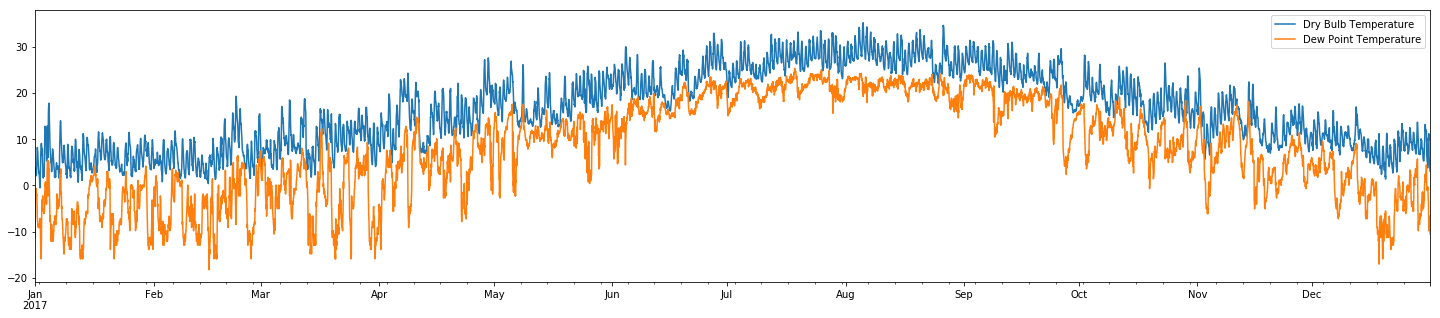

In [20]:
df_num[['Dry Bulb Temperature', 'Dew Point Temperature']].plot(subplots=False, figsize=(25, 5))

#### Scatter Plot (hacked heatmap...)

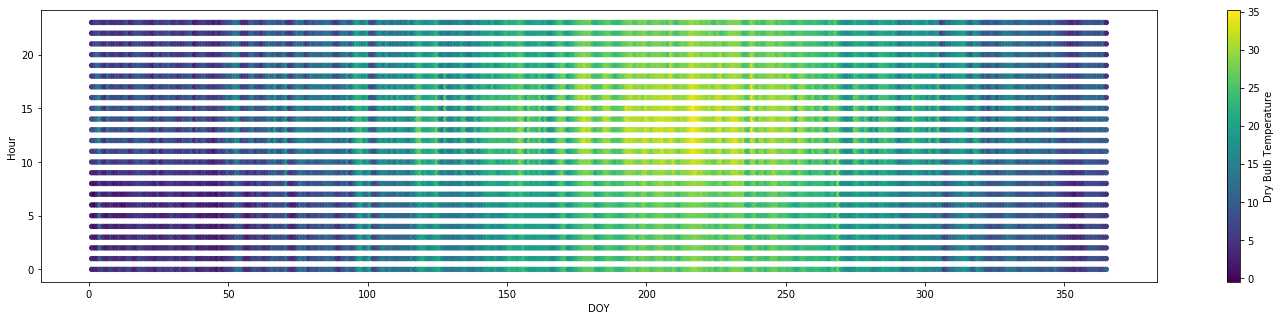

In [21]:

df_num['DOY'] = df.index.dayofyear
df_num['Hour'] = df.index.hour

df_num.plot(kind='scatter', x='DOY', y='Hour', c='Dry Bulb Temperature', cmap='viridis', figsize=(25, 5))